## 0. Dependencies

In [1]:
import torch
from torch import nn

import torchvision
from torchvision.io import read_video

import numpy as np
import pandas as pd 
import os

from ibug.face_alignment import FANPredictor
from ibug.face_detection import RetinaFacePredictor

In [44]:
!pip list --format=freeze > requirements_retinaface.txt

## 1. Device Agnostic Code 

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [46]:
sample_path = "data/lipread_mp4/ABOUT/train/ABOUT_00002.mp4"
sample_label = "ABOUT"

## 2. Landmarks Detector

In [23]:
face_detector = RetinaFacePredictor(device=device, threshold=0.8)
landmark_detector = FANPredictor(device=device)

In [24]:
from torchvision.io import read_video

video_frames = read_video(filename=sample_path, pts_unit='sec')[0].numpy()

NameError: name 'sample_path' is not defined

In [ ]:
%%time
landmarks = []
for frame in video_frames:
    detected_faces = face_detector(frame, rgb=False)
    face_points, _ = landmark_detector(frame, detected_faces, rgb=True)
    if len(detected_faces) == 0:
        landmarks.append(None)
    else:
        max_id, max_size = 0, 0
        for idx, bbox in enumerate(detected_faces):
            bbox_size = (bbox[2] - bbox[0]) + (bbox[3] - bbox[1])
            if bbox_size > max_size:
                max_id, max_size = idx, bbox_size
        landmarks.append(face_points[max_id])
landmarks

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
plt.imshow(video_frames[0])
plt.scatter(landmarks[0][:,0], landmarks[0][:, 1], marker='.', c='r')

### OOP

In [52]:
# %%writefile modular/detector/detector.py

"""Defines a LandmarksDetector class that uses RetinaFace to detect faces
and return the landmarks of the face with biggest bounding box from the provided video file."""

import torch
from torchvision.io import read_video

from typing import List
import numpy as np

from ibug.face_detection import RetinaFacePredictor
from ibug.face_alignment import FANPredictor

class LandmarksDetector:
    def __init__(self, device: torch.device = 'cpu'):
        self.face_detector = RetinaFacePredictor(device=device, threshold=0.8)
        self.landmark_detector = FANPredictor(device=device)

    def __call__(self, filename: str) -> List[np.ndarray]:
        frames = read_video(filename=str(filename), pts_unit='sec')[0].numpy()
        landmarks = []

        for frame in frames:
            face_boxes = self.face_detector(image=frame, rgb=False)
            face_points, _ = self.landmark_detector(image=frame, face_boxes=face_boxes)

            if len(face_boxes) == 0:
                landmarks.append(None)
            else:
                # Find the largest face box
                get_size = lambda box: box[2]-box[0] + box[3]-box[1]
                max_idx, max_face_box = max(enumerate(face_boxes), key=lambda x: get_size(x[1]))

                landmarks.append(face_points[max_idx])

        return landmarks

In [53]:
test_detector = LandmarksDetector()
test = test_detector(sample_path)

In [54]:
test[0].shape

(68, 2)

### Testing

In [ ]:
%%time

from modular.detector.detector import LandmarksDetector

detector_test = LandmarksDetector(device=device)

In [ ]:
%%time 
detector_test("data/lipread_mp4/ABOUT/train/ABOUT_00002.mp4")

## Interpolation

In [3]:
def linear_interpolation(start_idx: int, end_idx: int, landmarks):
    """Defines a linear interpolation function to interpolate missing landmarks between indices

    Args:
        start_idx (int): An integer defining the starting index
        end_idx (int): An integer defining the stopping index
        landmarks: An array of size 68 containing the (x,y) values of the facial landmarks

    Returns:
        landmarks array after the missing points have been interpolated.
    """
    start_landmarks = landmarks[start_idx]
    end_landmarks = landmarks[end_idx]
    delta_idx = end_idx - start_idx
    delta_landmarks = end_landmarks - start_landmarks

    # Apply linear interpolation formula
    for idx in range(1, delta_idx):
        landmarks[idx + start_idx] = start_landmarks + delta_landmarks/delta_idx * idx
    return landmarks

In [4]:
def landmarks_interpolation(landmarks):
    """Adds the missing landmarks to the landmarks array

    Args:
        landmarks: An array containing all the detected landmarks

    Returns:
        landmarks array filled in with missing landmarks
    """
    # Obtain indices of all the valid landmarks (i.e landmarks not None)
    valid_landmarks_idx = [idx for idx, _ in enumerate(landmarks) if _ is not None]
    
    if not valid_landmarks_idx:
        return

    # For middle parts of the landmarks array
    for idx in range(1, len(valid_landmarks_idx)):
        # If the valid landmarks indices are adjacent then skip to next iteration
        if valid_landmarks_idx[idx]-valid_landmarks_idx[idx-1] > 1:
            landmarks = linear_interpolation(start_idx=valid_landmarks_idx[idx-1],
                                            end_idx=valid_landmarks_idx[idx],
                                            landmarks=landmarks)

    # For beginning and ending parts of the landmarks array
    valid_landmarks_idx = [idx for idx, _ in enumerate(landmarks) if _ is not None]
    landmarks[:valid_landmarks_idx[0]] = [landmarks[valid_landmarks_idx[0]]] * valid_landmarks_idx[0]
    landmarks[valid_landmarks_idx[-1]:] = [landmarks[valid_landmarks_idx[-1]]] * (len(landmarks) - valid_landmarks_idx[-1])

    return landmarks

### Modular

In [59]:
%%writefile modular/interpolation.py

"""Defines the interpolation functions to fill the missing landmarks in the landmarks array"""

def linear_interpolation(start_idx: int, end_idx: int, landmarks):
    """Defines a linear interpolation function to interpolate missing landmarks between indices

    Args:
        start_idx (int): An integer defining the starting index
        end_idx (int): An integer defining the stopping index
        landmarks: An array of size 68 containing the (x,y) values of the facial landmarks

    Returns:
        landmarks array after the missing points have been interpolated.
    """
    start_landmarks = landmarks[start_idx]
    end_landmarks = landmarks[end_idx]
    delta_idx = end_idx - start_idx
    delta_landmarks = end_landmarks - start_landmarks

    # Apply linear interpolation formula
    for idx in range(1, delta_idx):
        landmarks[idx + start_idx] = start_landmarks + delta_landmarks/delta_idx * idx
    return landmarks


def landmarks_interpolation(landmarks):
    """Adds the missing landmarks to the landmarks array

    Args:
        landmarks: An array containing all the detected landmarks

    Returns:
        landmarks array filled in with missing landmarks
    """
    # Obtain indices of all the valid landmarks (i.e landmarks not None)
    valid_landmarks_idx = [idx for idx, _ in enumerate(landmarks) if _ is not None]
    
    if not valid_landmarks_idx:
        return

    # For middle parts of the landmarks array
    for idx in range(1, len(valid_landmarks_idx)):
        # If the valid landmarks indices are adjacent then skip to next iteration
        if valid_landmarks_idx[idx]-valid_landmarks_idx[idx-1] > 1:
            landmarks = linear_interpolation(start_idx=valid_landmarks_idx[idx-1],
                                            end_idx=valid_landmarks_idx[idx],
                                            landmarks=landmarks)

    # For beginning and ending parts of the landmarks array
    valid_landmarks_idx = [idx for idx, _ in enumerate(landmarks) if _ is not None]
    landmarks[:valid_landmarks_idx[0]] = [landmarks[valid_landmarks_idx[0]]] * valid_landmarks_idx[0]
    landmarks[valid_landmarks_idx[-1]:] = [landmarks[valid_landmarks_idx[-1]]] * (len(landmarks) - valid_landmarks_idx[-1])

    return landmarks

Overwriting modular/interpolation.py


## Affine Transformation

In [1]:
%%writefile modular/transform.py

import cv2

class VideoProcess:
    def __init__(self, mean_landmarks_path: str):
        # For warping the frames
        self.mean_landmarks = np.load(mean_landmarks_path)
        self.stable_points=(28, 33, 36, 39, 42, 45, 48, 54)
        self.reference_landmarks = np.vstack([self.mean_landmarks[x] for x in self.stable_points])

        # Cropping
        self.crop_height = 96
        self.crop_width = 96
        self.temporal_window = 12

    def __call__(self, video_path, landmarks):
        video,_,_ = read_video(str(video_path), pts_unit='sec')
        landmarks = landmarks_interpolation(landmarks)

        if not landmarks or len(landmarks) < self.temporal_window:
            return 

        mouth_rois = self.crop_video(video.numpy(), landmarks)
        return mouth_rois

    
    # Affine Transformation (Rotation, Translation and Scaling)
    def _get_transform(self, src_points: np.ndarray) -> np.ndarray:
        transform, _ = cv2.estimateAffinePartial2D(src_points, self.reference_landmarks, method=cv2.LMEDS)
        return transform

    def warp_frame(self, frame, landmarks):
        # Convert frame to grayscale
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        
        # Extract only stable points from current landmarks
        stable_points_landmarks = np.vstack([landmarks[x] for x in self.stable_points])

        transform_matrix = self._get_transform(stable_points_landmarks)
        transformed_frame = cv2.warpAffine(frame, transform_matrix, dsize=(256,256))
        transformed_landmarks = np.matmul(landmarks, transform_matrix[:, :2].transpose()) + transform_matrix[:, 2].transpose()
        
        return transformed_frame, transformed_landmarks


    # Crop Frames (Obtain Mouth ROI)
    def _cut_mouth(self, frame, landmarks, height, width):
        center_x, center_y = np.mean(landmarks, axis=0)

        # Calculate bounding box coordinates
        y_min = int(round(np.clip(center_y - height, 0, 256)))
        y_max = int(round(np.clip(center_y + height, 0, 256)))
        x_min = int(round(np.clip(center_x - width, 0, 256)))
        x_max = int(round(np.clip(center_x + width, 0, 256)))
        mouth_roi = frame[y_min:y_max, x_min:x_max]
        return mouth_roi

    def crop_video(self, video, landmarks_list):
        mouth_rois = []
        for idx, frame in enumerate(video):
            window_margin = min(self.temporal_window//2, idx, len(landmarks_list)-idx-1)

            average_landmarks_temporal = np.mean([landmarks_list[x] for x in range(idx-window_margin, idx+window_margin+1)], axis=0)
            average_landmarks_temporal += landmarks_list[idx].mean(axis=0) - average_landmarks_temporal.mean(axis=0)

            transformed_frame, transformed_landmarks = self.warp_frame(frame, average_landmarks_temporal)

            mouth = self._cut_mouth(transformed_frame, transformed_landmarks[48:68], height=self.crop_height//2, width=self.crop_width//2)

            mouth_rois.append(mouth)
        # print(mouth_rois)
        return np.array(mouth_rois)

Writing modular/transform.py


## Compute Landmarks

**Do not execute**

In [7]:
%%time

from modular.detector.detector import LandmarksDetector

landmark_detector = LandmarksDetector(device=device)

CPU times: user 1.68 s, sys: 50.7 ms, total: 1.73 s
Wall time: 1.95 s


In [8]:
import os
from pathlib import Path

import pandas as pd

In [11]:
train_df = pd.read_pickle("dataframe/train_df_50lab_1000train_50val_50test.pkl")

train_df.head()

,path,label,split
0,data/lipread_mp4/HUNDREDS/train/HUNDREDS_00738...,HUNDREDS,train
1,data/lipread_mp4/HUNDREDS/train/HUNDREDS_00206...,HUNDREDS,train
2,data/lipread_mp4/HUNDREDS/train/HUNDREDS_00502...,HUNDREDS,train
3,data/lipread_mp4/HUNDREDS/train/HUNDREDS_00345...,HUNDREDS,train
4,data/lipread_mp4/HUNDREDS/train/HUNDREDS_00852...,HUNDREDS,train


In [12]:
len(train_df)

48962

In [21]:
%%time
from tqdm.auto import tqdm

tqdm.pandas()
train_df['landmarks'] = train_df['path'].progress_apply(landmark_detector)

  0%|          | 0/48962 [00:00<?, ?it/s]


KeyboardInterrupt



In [13]:
test_df = pd.read_pickle("dataframe/test_df_50lab_1000train_50val_50test.pkl")
val_df = pd.read_pickle("dataframe/val_df_50lab_1000train_50val_50test.pkl")

In [22]:
%%time

test_df['landmarks'] = test_df['path'].progress_apply(landmark_detector)
val_df['landmarks'] = val_df['path'].progress_apply(landmark_detector)

  0%|          | 0/2500 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [23]:
val_df.head()

,path,label,split
0,data/lipread_mp4/HUNDREDS/val/HUNDREDS_00041.mp4,HUNDREDS,val
1,data/lipread_mp4/HUNDREDS/val/HUNDREDS_00038.mp4,HUNDREDS,val
2,data/lipread_mp4/HUNDREDS/val/HUNDREDS_00024.mp4,HUNDREDS,val
3,data/lipread_mp4/HUNDREDS/val/HUNDREDS_00019.mp4,HUNDREDS,val
4,data/lipread_mp4/HUNDREDS/val/HUNDREDS_00018.mp4,HUNDREDS,val


In [23]:
test_df.head()


KeyboardInterrupt



In [ ]:
train_df.to_pickle("landmarks/train_df_with_landmarks.pkl")
test_df.to_pickle("landmarks/test_df_with_landmarks.pkl")
val_df.to_pickle("landmarks/val_df_with_landmarks.pkl")

### Save as .pkl file

Save the landmarks in `landmarks/<label>/<split>/filename.pkl`
> Eg. landmarks/HUNDREDS/train/HUNDREDS_00001.pkl

In [12]:
import os
import numpy as np
import pandas as pd

output_directory = "landmarks/computed/"

def save_landmarks(df: pd.DataFrame) -> None:
    for idx, row in df.iterrows():
        components = str(row['path']).split('/')
        label = components[-3]
        split = components[-2]
        filename = components[-1].split('.')[0]

        # Create directory 
        save_dir = os.path.join(output_directory, label, split)
        os.makedirs(save_dir, exist_ok=True)


        # Save landmarks
        file_path = os.path.join(save_dir, filename+'.pkl')
        with open(file_path, 'wb') as file:
            pickle.dump(row['landmarks'], file)

In [6]:
train_df = pd.read_pickle('landmarks/train_df_with_landmarks.pkl')
test_df = pd.read_pickle('landmarks/test_df_with_landmarks.pkl')
val_df = pd.read_pickle('landmarks/val_df_with_landmarks.pkl')

In [20]:
%%time

save_landmarks(train_df)
save_landmarks(test_df)
save_landmarks(val_df)

CPU times: user 8.77 s, sys: 2.82 s, total: 11.6 s
Wall time: 12.2 s


In [9]:
test_df

,path,label,split,landmarks
0,data/lipread_mp4/HUNDREDS/test/HUNDREDS_00041.mp4,HUNDREDS,test,"[[[71.31809, 85.32948], [70.35795, 101.36151],..."
1,data/lipread_mp4/HUNDREDS/test/HUNDREDS_00038.mp4,HUNDREDS,test,"[[[77.19481, 118.160805], [79.41128, 132.01007..."
2,data/lipread_mp4/HUNDREDS/test/HUNDREDS_00024.mp4,HUNDREDS,test,"[[[50.837456, 75.2955], [53.087498, 94.72337],..."
3,data/lipread_mp4/HUNDREDS/test/HUNDREDS_00019.mp4,HUNDREDS,test,"[[[72.97648, 90.28793], [73.85288, 107.57341],..."
4,data/lipread_mp4/HUNDREDS/test/HUNDREDS_00018.mp4,HUNDREDS,test,"[[[61.28248, 113.27446], [63.205994, 128.76273..."
...,...,...,...,...
2495,data/lipread_mp4/GREAT/test/GREAT_00044.mp4,GREAT,test,"[[[54.5991, 100.90286], [57.263668, 117.41515]..."
2496,data/lipread_mp4/GREAT/test/GREAT_00001.mp4,GREAT,test,"[[[33.813316, 105.22418], [36.958332, 123.7727..."
2497,data/lipread_mp4/GREAT/test/GREAT_00004.mp4,GREAT,test,"[[[53.652363, 117.90432], [56.6435, 133.02452]..."
2498,data/lipread_mp4/GREAT/test/GREAT_00009.mp4,GREAT,test,"[[[75.98874, 88.40811], [75.49105, 105.41622],..."


In [40]:
np.load('landmarks/computed/HUNDREDS/train/HUNDREDS_00206.npy')

array([[[ 73.26416 ,  95.99261 ],
        [ 69.30762 , 111.158875],
        [ 67.05806 , 127.505554],
        ...,
        [136.1338  , 162.06987 ],
        [129.18246 , 161.06702 ],
        [122.14645 , 158.92091 ]],

       [[ 72.77987 ,  97.05281 ],
        [ 69.31474 , 112.0856  ],
        [ 66.71345 , 128.10416 ],
        ...,
        [135.57643 , 162.81451 ],
        [128.49794 , 161.90474 ],
        [121.52952 , 159.51587 ]],

       [[ 71.41318 ,  98.19014 ],
        [ 69.07094 , 113.858635],
        [ 67.13641 , 130.04634 ],
        ...,
        [137.05133 , 162.26129 ],
        [130.04147 , 161.40096 ],
        [122.86978 , 159.11572 ]],

       ...,

       [[ 88.501686,  87.8271  ],
        [ 82.178535, 103.27815 ],
        [ 77.40576 , 120.55295 ],
        ...,
        [136.78218 , 164.75372 ],
        [128.88252 , 162.91853 ],
        [121.615715, 160.20415 ]],

       [[ 89.99234 ,  84.64305 ],
        [ 84.187096, 100.384964],
        [ 79.33688 , 117.74397 ],
        .

In [41]:
train_df.iloc[1]['landmarks']

[array([[ 73.26416 ,  95.99261 ],
        [ 69.30762 , 111.158875],
        [ 67.05806 , 127.505554],
        [ 65.738464, 141.53648 ],
        [ 66.58942 , 157.72018 ],
        [ 72.00723 , 172.47446 ],
        [ 81.90879 , 183.7911  ],
        [ 97.14123 , 193.24138 ],
        [117.29581 , 201.82002 ],
        [137.41766 , 202.50986 ],
        [149.46599 , 201.33937 ],
        [160.36198 , 197.7073  ],
        [171.6009  , 187.51923 ],
        [179.54118 , 172.30415 ],
        [186.15573 , 157.98456 ],
        [191.39558 , 142.71881 ],
        [194.42293 , 127.19623 ],
        [ 96.088104,  75.8632  ],
        [106.42148 ,  70.671974],
        [116.63313 ,  69.85103 ],
        [126.088196,  71.89113 ],
        [133.79904 ,  75.92451 ],
        [164.17203 ,  84.13345 ],
        [171.83087 ,  83.84526 ],
        [180.53766 ,  86.728676],
        [187.91917 ,  91.182076],
        [192.03313 ,  99.61089 ],
        [144.7908  ,  98.41766 ],
        [143.57892 , 107.877396],
        [142.0

## Compute Mouth ROI

**Do not execute**

In [7]:
video_process = VideoProcess(mean_landmarks_path='mean_landmarks/20words_mean_face.npy')

In [8]:
mouth = video_process(train_df.iloc[0]['path'], train_df.iloc[0]['landmarks'])

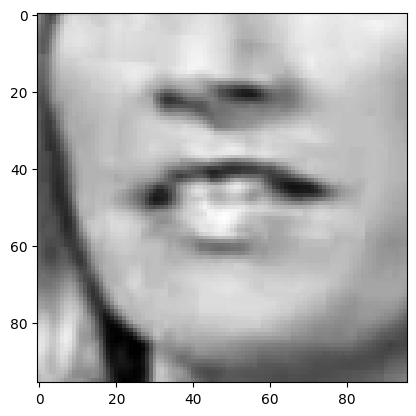

In [9]:
import matplotlib.pyplot as plt

plt.imshow(mouth[0], cmap='gray')

In [18]:
from tqdm.auto import tqdm

def save_mouth_rois(df: pd.DataFrame) -> None:
    mouth_rois = []
    filename = []
    roi_dict = {}
    save_path = 'mouth/roi/'
   
    for idx, row in tqdm(df.iterrows(), total=df.shape[0]):
        path = str(row['path'])
        mouth_roi = video_process(path, row['landmarks'])

        label = row['label']
        split, filename = path.split('/')[-2:]

        filename = filename.split('.')[0]

        file_path = os.path.join(save_path,label,split)

        os.makedirs(file_path, exist_ok=True)

        npy_file_path = os.path.join(file_path, f"{filename}.npy")
        np.save(npy_file_path, arr=mouth_roi)

In [19]:
%%time
save_mouth_rois(pd.concat([train_df, test_df, val_df]))

  0%|          | 0/53962 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [12]:
from multiprocessing import Pool
from tqdm.auto import tqdm

def save_mouth_roi_parallel(args):
    idx, row, save_path = args
    path = str(row['path'])
    mouth_roi = video_process(path, row['landmarks'])

    label = row['label']
    split, filename = path.split('/')[-2:]

    filename = filename.split('.')[0]

    file_path = os.path.join(save_path, label, split)
    os.makedirs(file_path, exist_ok=True)

    npy_file_path = os.path.join(file_path, f"{filename}.npy")
    np.save(npy_file_path, arr=mouth_roi)

def save_mouth_rois_parallel(df: pd.DataFrame, batch_size: int=15, desc: str = None) -> None:
    save_path = 'mouth/roi/'

    for batch_df in tqdm(np.array_split(df, len(df) // batch_size), desc=desc):
        args_list = [(idx, row, save_path) for idx, row in batch_df.iterrows()]

        with Pool(processes=os.cpu_count()) as pool:
            list(pool.imap_unordered(save_mouth_roi_parallel, args_list))

save_mouth_rois_parallel(train_df, desc="Train")

save_mouth_rois_parallel(test_df, desc="Test")

save_mouth_rois_parallel(val_df, desc="Val")



/home/anujm/miniconda3/envs/VSR/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Train:   0%|          | 0/3264 [00:00<?, ?it/s]

Test:   0%|          | 0/166 [00:00<?, ?it/s]

Val:   0%|          | 0/166 [00:00<?, ?it/s]

In [191]:
val_df

,path,label,landmarks,split
0,data/lipread_mp4/HUNDREDS/val/HUNDREDS_00041.mp4,HUNDREDS,"[[[68.73233, 99.89485], [70.63492, 115.24597],...",val
1,data/lipread_mp4/HUNDREDS/val/HUNDREDS_00038.mp4,HUNDREDS,"[[[36.586792, 97.17292], [40.370026, 114.38685...",val
2,data/lipread_mp4/HUNDREDS/val/HUNDREDS_00024.mp4,HUNDREDS,"[[[41.05754, 104.408066], [43.290985, 122.3381...",val
3,data/lipread_mp4/HUNDREDS/val/HUNDREDS_00019.mp4,HUNDREDS,"[[[66.4197, 80.571625], [67.97587, 97.77672], ...",val
4,data/lipread_mp4/HUNDREDS/val/HUNDREDS_00018.mp4,HUNDREDS,"[[[42.07781, 101.683], [45.211914, 119.02557],...",val
...,...,...,...,...
2465,data/lipread_mp4/GREAT/val/GREAT_00037.mp4,GREAT,"[[[102.616394, 105.323], [101.36221, 120.724],...",val
2466,data/lipread_mp4/GREAT/val/GREAT_00047.mp4,GREAT,"[[[37.591026, 89.17265], [37.82675, 108.63196]...",val
2467,data/lipread_mp4/GREAT/val/GREAT_00020.mp4,GREAT,"[[[66.60347, 101.93374], [67.46085, 118.05652]...",val
2468,data/lipread_mp4/GREAT/val/GREAT_00045.mp4,GREAT,"[[[62.36702, 110.00241], [62.523643, 125.92657...",val


In [210]:
rois = np.load('mouth/mouth_roi.npz')

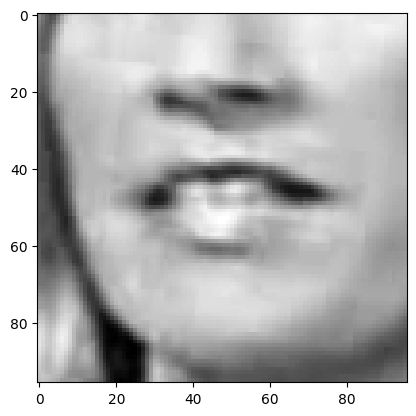

In [213]:
plt.imshow(rois['HUNDREDS_00738#train'][0], cmap='gray')

In [5]:
import numpy as np
import os 

mouth_path = "mouth/"
mouth_npz = np.load(mouth_path+"mouth_roi.npz")

roi_folder = os.path.join(mouth_path, "roi")

if not os.path.exists(roi_folder):
    os.makedirs(roi_folder)

for item_name in mouth_npz.files:
    label, _ = item_name.split('_')
    filename, split = item_name.split('#')

    label_folder_path = os.path.join(roi_folder, label)
    os.makedirs(label_folder_path, exist_ok=True)

    split_folder_path = os.path.join(label_folder_path, split)
    os.makedirs(split_folder_path, exist_ok=True)

    npy_file_path = os.path.join(split_folder_path, f"{filename}.npy")
    np.save(npy_file_path, arr=mouth_npz[item_name])
    

## Train and Test Functions

In [3]:
import torch

from typing import Tuple, Dict, List
from tqdm.auto import tqdm

def train_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              optimizer: torch.optim.Optimizer,
              device: torch.device='cpu') -> Tuple[float, float]:

    """This function defines the training step for a model.
    
    Args:
        model (torch.nn.Module): The model that is to be trained.
        dataloader (torch.utils.data.DataLoader): The training dataloader
        loss_fn (torch.nn.Module): Loss function to evaluate the model
        optimizer (torch.optim.Optimizer): Optimizer for updating the model parameters.
        device (torch.device): The device used to train the model. Default='cpu'

    Returns:
        A tuple consisting the train loss and accuracy for an epoch.

        Example Usage: train_loss, train_acc = train_step(model=model, dataloader=train_dataloader, loss_fn=loss_fn, optimizer=optimizer, device=device)
    """

    model.train()
    train_loss = 0
    train_acc = 0
    
    for batch,(X,y) in enumerate(tqdm(dataloader, desc="Train")):
        X,y = X.to(device), y.to(device)
        X = X.unsqueeze(dim=1)
        X = X.type(torch.float32)
        # Optimizer zero grad
        optimizer.zero_grad()
        # Forward pass
        y_logits = model(X)

        # Calculate loss
        loss = loss_fn(y_logits, y)
        train_loss += loss.item()

        # Back Propagation
        loss.backward()

        # Optimizer Step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_logits, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_logits)

    train_loss = train_loss/len(dataloader)
    train_acc = train_acc/len(dataloader)
    return train_loss, train_acc

In [4]:
def val_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device='cpu') -> Tuple[float, float]:
    """This function defines the validation step for a model.
    
    Args:
        model (torch.nn.Module): The model that is to be validated.
        dataloader (torch.utils.data.DataLoader): The validation dataloader
        loss_fn (torch.nn.Module): Loss function to evaluate the model
        device (torch.device): The device used to train the model. Default='cpu'

    Returns:
        A tuple consisting the validation loss and accuracy for an epoch.

        Example Usage: val_loss, val_acc = val_step(model=model, dataloader=val_dataloader, loss_fn=loss_fn, device=device)
    """
    model.eval()
    val_loss = 0
    val_acc = 0

    with torch.inference_mode():
        for batch,(X,y) in enumerate(tqdm(dataloader, desc="Val")):
            X,y = X.to(device), y.to(device)
            X = X.unsqueeze(dim=1)
            X = X.type(torch.float32)
            
            # Forward pass
            y_logits = model(X)
    
            # Calculate loss
            loss = loss_fn(y_logits, y)
            val_loss += loss

            # Calculate and accumulate accuracy
            y_labels = y_logits.argmax(dim=1)
            val_acc += ((y_labels == y).sum().item()/len(y_labels))

    val_loss = val_loss/len(dataloader)
    val_acc = val_acc/len(dataloader)
    return val_loss, val_acc

In [5]:
def train(model: torch.nn.Module,
         train_dataloader: torch.utils.data.DataLoader,
         val_dataloader: torch.utils.data.DataLoader,
         loss_fn: torch.nn.Module,
         optimizer: torch.optim.Optimizer,
         epochs: int = 32,
         device: torch.device = 'cpu') -> Dict[str, List[float]]:
    """This function defines the training functionality of the model.
    
    Args:
        model (torch.nn.Module): The model that is to be trained.
        train_dataloader (torch.utils.data.DataLoader): The training dataloader
        val_dataloader (torch.utils.data.DataLoader): The validation dataloader
        loss_fn (torch.nn.Module): Loss function to evaluate the model
        optimizer (torch.optim.Optimizer): Optimizer for updating the model parameters.
        epochs (int): Number of epochs. Default=32
        device (torch.device): The device used to train the model. Default='cpu'

    Returns:
        A tuple consisting the train loss and accuracy for an epoch.

        Example Usage: train_loss, train_acc, val_loss, val_acc = train(model=model, train_dataloader=train_dataloader, val_dataloader=val_dataloader, loss_fn=loss_fn,
                                                                        optimizer=optimizer, epochs=32, device=device)
    """
    model_results = {'model_name': model.__class__.__name__,
                    'train_loss': [],
                    'train_acc': [],
                    'val_loss': [],
                    'val_acc': []}
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                dataloader=train_dataloader,
                                loss_fn=loss_fn,
                                optimizer=optimizer,
                                device=device)
        val_loss, val_acc = val_step(model=model,
                           dataloader=val_dataloader,
                           loss_fn=loss_fn,
                           device=device)

        model_results['train_loss'].append(train_loss)
        model_results['train_acc'].append(train_acc)
        model_results['val_loss'].append(val_loss)
        model_results['val_acc'].append(val_acc)
        print(f"Epoch: {epoch} | Train Loss: {train_loss:.2f} | Train Acc: {train_acc:.2f}% | Val Loss: {val_loss:.2f} | Val Acc: {val_acc:.2f}%")

    return model_results

### Modular

In [21]:
%%writefile modular/train.py

"""This module consists of the function required to train the model."""


import torch

from typing import Tuple, Dict, List

def train_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              optimizer: torch.optim.Optimizer,
              device: torch.device='cpu') -> Tuple[float, float]:

    """This function defines the training step for a model.
    
    Args:
        model (torch.nn.Module): The model that is to be trained.
        dataloader (torch.utils.data.DataLoader): The training dataloader
        loss_fn (torch.nn.Module): Loss function to evaluate the model
        optimizer (torch.optim.Optimizer): Optimizer for updating the model parameters.
        device (torch.device): The device used to train the model. Default='cpu'

    Returns:
        A tuple consisting the train loss and accuracy for an epoch.

        Example Usage: train_loss, train_acc = train_step(model=model, dataloader=train_dataloader, loss_fn=loss_fn, optimizer=optimizer, device=device)
    """

    model.train()
    train_loss = 0
    train_acc = 0
    
    for batch,(X,y) in enumerate(dataloader):
        X,y = X.to(device), y.to(device)

        # Optimizer zero grad
        optimizer.zero_grad()

        # Forward pass
        y_logits = model(X)

        # Calculate loss
        loss = loss_fn(y_logits, y)
        train_loss += loss.item()

        # Back Propagation
        loss.backward()

        # Optimizer Step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_logits, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_logits)

    train_loss = train_loss/len(dataloader)
    train_acc = train_acc/len(dataloader)
    return train_loss, train_acc


def val_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device='cpu') -> Tuple[float, float]:
    """This function defines the validation step for a model.
    
    Args:
        model (torch.nn.Module): The model that is to be validated.
        dataloader (torch.utils.data.DataLoader): The validation dataloader
        loss_fn (torch.nn.Module): Loss function to evaluate the model
        device (torch.device): The device used to train the model. Default='cpu'

    Returns:
        A tuple consisting the validation loss and accuracy for an epoch.

        Example Usage: val_loss, val_acc = val_step(model=model, dataloader=val_dataloader, loss_fn=loss_fn, device=device)
    """
    model.eval()
    val_loss = 0
    val_acc = 0

    with torch.inference_mode():
        for batch,(X,y) in enumerate(dataloader):
            X,y = X.to(device), y.to(device)
    
            # Forward pass
            y_logits = model(X)
    
            # Calculate loss
            loss = loss_fn(y_logits, y)
            val_loss += loss

            # Calculate and accumulate accuracy
            y_labels = y_logits.argmax(dim=1)
            val_acc += ((y_labels == y).sum().item()/len(y_labels))

    val_loss = val_loss/len(dataloader)
    val_acc = val_acc/len(dataloader)
    return val_loss, val_acc


def train(model: torch.nn.Module,
         train_dataloader: torch.utils.data.DataLoader,
         val_dataloader: torch.utils.data.DataLoader,
         loss_fn: torch.nn.Module,
         optimizer: torch.optim.Optimizer,
         epochs: int = 32,
         device: torch.device = 'cpu') -> Dict[str, List[float]]:
    """This function defines the training functionality of the model.
    
    Args:
        model (torch.nn.Module): The model that is to be trained.
        train_dataloader (torch.utils.data.DataLoader): The training dataloader
        val_dataloader (torch.utils.data.DataLoader): The validation dataloader
        loss_fn (torch.nn.Module): Loss function to evaluate the model
        optimizer (torch.optim.Optimizer): Optimizer for updating the model parameters.
        epochs (int): Number of epochs. Default=32
        device (torch.device): The device used to train the model. Default='cpu'

    Returns:
        A tuple consisting the train loss and accuracy for an epoch.

        Example Usage: train_loss, train_acc, val_loss, val_acc = train(model=model, train_dataloader=train_dataloader, val_dataloader=val_dataloader, loss_fn=loss_fn,
                                                                        optimizer=optimizer, epochs=32, device=device)
    """
    model_results = {'model_name': model.__class__.__name__,
                    'train_loss': [],
                    'train_acc': [],
                    'val_loss': [],
                    'val_acc': []}
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                dataloader=train_dataloader,
                                loss_fn=loss_fn,
                                optimizer=optimizer,
                                device=device)
        val_loss, val_acc = val_step(model=model,
                           dataloader=val_dataloader,
                           loss_fn=loss_fn,
                           device=device)

        model_results['train_loss'].append(train_loss)
        model_results['train_acc'].append(train_acc)
        model_results['val_loss'].append(val_loss)
        model_results['val_acc'].append(val_acc)
        print(f"Epoch: {epoch} | Train Loss: {train_loss:.2f} | Train Acc: {train_acc:.2f}% | Val Loss: {val_loss:.2f} | Val Acc: {val_acc:.2f}%")

    return model_results

Overwriting modular/train.py


## Dataset and Dataloader

In [6]:
from torch.utils.data import Dataset

class LRWDataset(Dataset):
    def __init__(self, df, transforms=None):
        self.df = df
        self.transforms = transforms

        self.classes = self.df['label'].unique()
        self.class_to_idx = {classname: idx for idx, classname in enumerate(self.classes)}

    def get_mouth_roi(self, path):
        tokens = path.split('/')
        label, split, filename = tokens[-3:]
        filename = filename.split('.')[0]

        roi = np.load(os.path.join('mouth/roi/', label, split, filename+'.npy'))
        return roi, label

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        path = self.df.iloc[idx]['path']
        roi, label = self.get_mouth_roi(str(path))
        class_idx = self.class_to_idx[label]

        if self.transforms:
            return self.transforms(roi), class_idx

        return roi, class_idx

In [7]:
import pandas as pd

train_df = pd.read_pickle("dataframe/train_df_50lab_1000train_50val_50test.pkl")
test_df = pd.read_pickle("dataframe/test_df_100lab_1000train_50val_50test.pkl")
val_df = pd.read_pickle("dataframe/val_df_50lab_1000train_50val_50test.pkl")


In [8]:
train_data = LRWDataset(df=train_df)
test_data = LRWDataset(df=test_df)
val_data = LRWDataset(df=val_df)

In [9]:
from torch.utils.data import DataLoader

class PrefetchDataLoader(DataLoader):
    def __iter__(self):
        self._iterator = super().__iter__()

        self._prefetch()

        return self

    def _prefetch(self):
        try:
            self._prefetched_batch = next(self._iterator)
        except StopIteration:
            self._prefetched_batch = None

    def __next__(self):
        # Get the current batch
        batch = self._prefetched_batch

        # Prefetch the next batch
        self._prefetch()

        return batch

In [21]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32
NUM_WORKERS = 4

train_dataloader = DataLoader(dataset=train_data,
                             num_workers=NUM_WORKERS,
                             shuffle=True,
                             pin_memory=True,
                             batch_size=BATCH_SIZE)

test_dataloader = DataLoader(dataset=test_data,
                            num_workers=NUM_WORKERS,
                            shuffle=False,
                            batch_size=BATCH_SIZE)


val_dataloader = DataLoader(dataset=val_data,
                            num_workers=NUM_WORKERS,
                            shuffle=False,
                            batch_size=BATCH_SIZE,
                            pin_memory=True)

In [11]:
next(iter(train_dataloader))[0].shape

torch.Size([32, 29, 96, 96])

## Create Model

### Baseline Model

In [22]:
class LipReadingModel(nn.Module):
    def __init__(self, num_classes=50):
        super(LipReadingModel, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv3d(1, 64, kernel_size=(3, 5, 5), stride=(1, 2, 2), padding=(1, 2, 2))
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2))
        
        self.conv2 = nn.Conv3d(64, 128, kernel_size=(3, 5, 5), stride=(1, 2, 2), padding=(1, 2, 2))
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2))
        
        # Fully connected layers
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 6 * 6 * 29, 512)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        # Input shape: (batch_size, channels, frames, height, width)
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)
        
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu3(x)
        logits = self.fc2(x)
        
        return logits

model_0 = LipReadingModel().to(device)

In [23]:
from torchinfo import summary

summary(model_0, input_size=[32,1,29,96,96])

Layer (type:depth-idx)                   Output Shape              Param #
LipReadingModel                          [32, 50]                  --
├─Conv3d: 1-1                            [32, 64, 29, 48, 48]      4,864
├─ReLU: 1-2                              [32, 64, 29, 48, 48]      --
├─MaxPool3d: 1-3                         [32, 64, 29, 24, 24]      --
├─Conv3d: 1-4                            [32, 128, 29, 12, 12]     614,528
├─ReLU: 1-5                              [32, 128, 29, 12, 12]     --
├─MaxPool3d: 1-6                         [32, 128, 29, 6, 6]       --
├─Flatten: 1-7                           [32, 133632]              --
├─Linear: 1-8                            [32, 512]                 68,420,096
├─ReLU: 1-9                              [32, 512]                 --
├─Linear: 1-10                           [32, 50]                  25,650
Total params: 69,065,138
Trainable params: 69,065,138
Non-trainable params: 0
Total mult-adds (Units.GIGABYTES): 94.71
Input size (MB):

In [ ]:
loss_fn = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.01)

In [19]:
train(model=model_0, train_dataloader=train_dataloader, val_dataloader=val_dataloader, loss_fn=loss_fn, optimizer=optimizer, device=device, epochs=10)

  0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/1531 [00:00<?, ?it/s]

TypeError: cannot unpack non-iterable NoneType object